# Классификация белков на семейства по их аминокислотным последовательностям

Используемые данные:

- pdb_data_seq.csv и pdb_data_no_dups.csv: https://www.kaggle.com/shahir/protein-data-set  
    (Датасет собран с RCSB PDB. Используется лишь как тренировочный набор данных)
- ly6upar.csv: известные и подтвержденные трехпетельные белки. Собран из данных Михаила Мышкина и всех результатов поиска на ncbi proteins по запросу Ly6/uPAR (https://www.ncbi.nlm.nih.gov/protein/?term=ly6%2Fupar)
- arubens_seq.csv и aplanci_seq.csv: протеом, полученный от Михаила Мышкина. Таргетный набор данных

модель взята здесь: https://www.kaggle.com/abharg16/predicting-protein-classification

### 1) Импорт библиотек и данных

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,\
precision_recall_fscore_support, log_loss, roc_curve

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
# from math import e as expon
import sklearn.metrics as metrics

# Все функции, которые писал для предобработки
from Utilities import *

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier

model_f = pd.read_csv('input/cl_input.csv', index_col=0)  # обработанный датасет из pdb
df_aru = pd.read_csv('input/arubens_seq.csv', index_col=0)  # протеом A. rubens
df_apl = pd.read_csv('input/aplanci_seq.csv', index_col=0)  # протеом A. planci
df_ly6 = pd.read_csv('input/ly6upar.csv', index_col=0)  # известные трехпетельные белки
df_ly6['classification'] = 'Ly6/uPAR' # дополнительный столбец под нужды модели

In [2]:
model_f.head()

,classification,sequence
structureId,,
101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
104L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSAA...


In [3]:
df_ly6.head()

,sequence,classification
genes,,
PF00087|P.ariabilis,MKTLVFVVLIIVAATEIASALKCYHCGPSSKSFKDCDANGKEMDCL...,Ly6/uPAR
JF274292|P.shermani,MRTTALLILLVVLFSTGEALQCNTLDGGTEECIPGIYNVCVHYKSE...,Ly6/uPAR
Lynx2|N.lugens,MERAKLSFSWVIACSLLVVLCFVVHKGSSIRCYQCNSEYDPTCGDP...,Ly6/uPAR
PSCA|G.gallus,MKVFFILLLAAILCTDPGSSLQCYSCKTKLSNSNCQATMNCKENEM...,Ly6/uPAR
ACVR1|H.sapiens,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...,Ly6/uPAR


### Предпроцессинг

(66,)


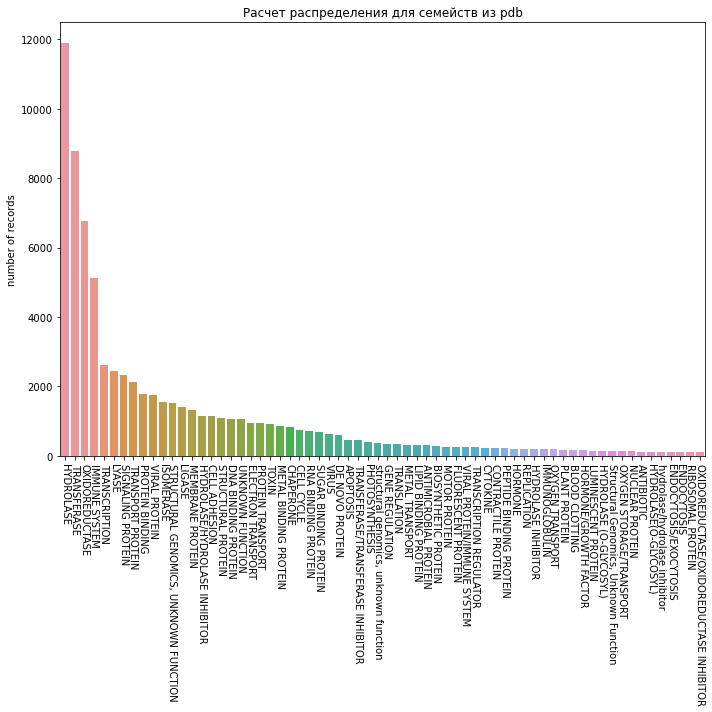

In [4]:
cou = model_f.classification.value_counts()
cou = cou[(cou > 100)]
print(cou.shape)  # Количество семейств белков, представленных в большем, чем 100 экземплярах

# Рисуем распределение
fig , ax = plt.subplots()
fig.set_size_inches(10, 10)
g = sns.barplot(x=cou.index, y=cou)
g.set_xticklabels(cou.index, rotation=-90)
plt.title('Расчет распределения для семейств из pdb')
plt.ylabel('number of records')
plt.tight_layout()
plt.show()

In [5]:
# Нормируем количество всех pdb белков на количество трехпетельных
x = df_ly6.shape[0] / cou.sum()  # нормировочный коэффицент
cou = (cou * x).apply(lambda x: round(x) + 1)  # Нормируем и округляем в большую сторону

# Используя написанную функцию, вытаскиваем из большого датасета количество белков
# по семействам (числа рассчитаны выше)
df_test = pd.DataFrame()
for i, j in zip(cou, cou.index):
    df_test = pd.concat([df_test, find_proteins(model_f, j, i, 3)])  

X_train, X_test, y_train, y_test = train_test(df_test, df_ly6)  # функция из utilities
y_train = label_binarize(y_train, classes=['NORES', 'Ly6/uPAR']).reshape(y_train.shape[0])
y_test = label_binarize(y_test, classes=['NORES', 'Ly6/uPAR']).reshape(y_test.shape[0])

In [6]:
# Проверяем правильность конкатенации (всего 227 трехпетельных белков)
X_train.shape[0] + X_test.shape[0] - df_test.shape[0]

227

### Исследование моделей

In [7]:
# Тест по случайным величинам
precision_r, recall_r, f1_score_r, res = [], [], [], y_test.copy()

for i in range(100):
    np.random.shuffle(res)
    tmp = precision_recall_fscore_support(y_pred=res, y_true=y_test, labels=[1])
    precision_r += [tmp[0][0]]
    recall_r += [tmp[1][0]]
    f1_score_r += [tmp[2][0]]

print('random precison = ', np.mean(precision_r))
print('random recall = ', np.mean(recall_r))
print('random f1 score = ', np.mean(f1_score_r))

random precison =  0.2154255319148936
random recall =  0.2154255319148936
random f1 score =  0.2154255319148936


In [8]:
# GridSearch по значениям nram для векторизатора

precision_SVC, recall_SVC, accuracy_SVC, f1_score_SVC, indexes_SVC = [], [], [], [], []
precision_NB, recall_NB, accuracy_NB, f1_score_NB, indexes_NB = [], [], [], [], []

log_loss_SVC, log_loss_NB = [], []

for i in range(2, 13):
    for j in range(i, 13):

        SVC_pipeline = Pipeline(steps=[
            ('tokenizer', CountVectorizer(analyzer = 'char_wb', ngram_range = (i, j))),
            ('model', LinearSVC(max_iter=100000, random_state=1, class_weight='balanced'))
            ])
        NB_pipeline = Pipeline(steps=[
            ('tokenizer', CountVectorizer(analyzer = 'char_wb', ngram_range = (i, j))),
            ('model', MultinomialNB())
            ])


        SVC_pipeline.fit(X_train, y_train)
        NB_pipeline.fit(X_train, y_train)

        SVC_pred = SVC_pipeline.predict(X_test)
        NB_pred = NB_pipeline.predict(X_test)

        accr_SVC = accuracy_score(SVC_pred, y_test)
        accr_NB = accuracy_score(NB_pred, y_test)
        
        f1_SVC = precision_recall_fscore_support(y_pred=SVC_pred, y_true=y_test, labels=[1])
        f1_NB = precision_recall_fscore_support(y_pred=NB_pred, y_true=y_test, labels=[1])
        
        loss_SVC = log_loss(y_pred=SVC_pred, y_true=y_test)
        loss_NB = log_loss(y_pred=NB_pred, y_true=y_test)

        print(i, j)
        print('accuracy SVC = ', accr_SVC)
        print('accuracy NB = ', accr_NB)
#         print(f"precison = {f1[0][0]}\nrecall = {f1[1][0]}\n")
        print('logistic Loss for SVC', loss_SVC)
        print('logistic Loss for NB', loss_NB)
        
        precision_SVC.append(f1_SVC[0][0]), recall_SVC.append(f1_SVC[1][0]), f1_score_SVC.append(f1_SVC[2][0])        
        accuracy_SVC.append(accr_SVC), indexes_SVC.append((i, j)), log_loss_SVC.append(loss_SVC)
        
        precision_NB.append(f1_NB[0][0]), recall_NB.append(f1_NB[1][0]), f1_score_NB.append(f1_NB[2][0])        
        accuracy_NB.append(accr_NB), indexes_NB.append((i, j)), log_loss_NB.append(loss_NB)


2 2
accuracy SVC =  0.9618834080717489
accuracy NB =  0.9147982062780269
logistic Loss for SVC 1.316511202462025
logistic Loss for NB 2.9428087294729397
2 3
accuracy SVC =  0.9775784753363229
accuracy NB =  0.9304932735426009
logistic Loss for SVC 0.7744156124304207
logistic Loss for NB 2.4007059681639342
2 4
accuracy SVC =  0.9753363228699552
accuracy NB =  0.9417040358744395
logistic Loss for SVC 0.8518568151095927
logistic Loss for NB 2.0134766481165216
2 5
accuracy SVC =  0.9775784753363229
accuracy NB =  0.9035874439461884
logistic Loss for SVC 0.7744156124304207
logistic Loss for NB 3.3299753008430946
2 6
accuracy SVC =  0.9730941704035875
accuracy NB =  0.8946188340807175
logistic Loss for SVC 0.9292980177887645
logistic Loss for NB 3.639738318740432
2 7
accuracy SVC =  0.9708520179372198
accuracy NB =  0.8878923766816144
logistic Loss for SVC 1.0067392204679364
logistic Loss for NB 3.8720619267779477
2 8
accuracy SVC =  0.9596412556053812
accuracy NB =  0.8878923766816144
logis

8 11
accuracy SVC =  0.8497757847533632
accuracy NB =  0.9147982062780269
logistic Loss for SVC 5.188560579504521
logistic Loss for NB 2.9427674946278843
8 12
accuracy SVC =  0.8497757847533632
accuracy NB =  0.9147982062780269
logistic Loss for SVC 5.188560579504521
logistic Loss for NB 2.9427674946278843
9 9
accuracy SVC =  0.8497757847533632
accuracy NB =  0.905829596412556
logistic Loss for SVC 5.188560579504521
logistic Loss for NB 3.2525323053445723
9 10
accuracy SVC =  0.8497757847533632
accuracy NB =  0.905829596412556
logistic Loss for SVC 5.188560579504521
logistic Loss for NB 3.2525323053445723
9 11
accuracy SVC =  0.8475336322869955
accuracy NB =  0.905829596412556
logistic Loss for SVC 5.266001782183692
logistic Loss for NB 3.2525323053445723
9 12
accuracy SVC =  0.8475336322869955
accuracy NB =  0.905829596412556
logistic Loss for SVC 5.266001782183692
logistic Loss for NB 3.2525323053445723
10 10
accuracy SVC =  0.8497757847533632
accuracy NB =  0.9035874439461884
logist

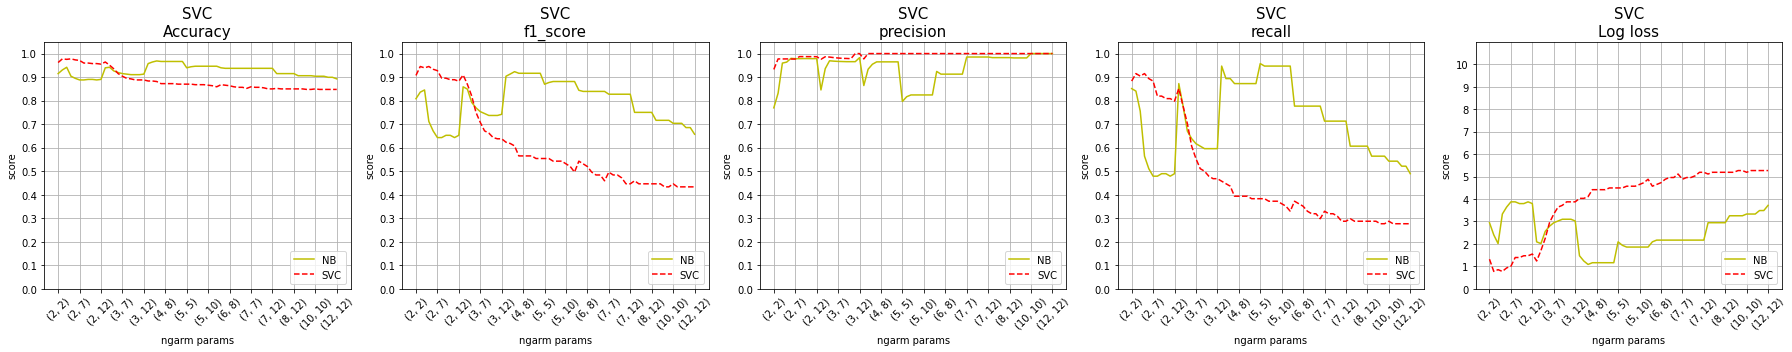

In [9]:
# Графики метрик для моделей по ngram парметру

fig, ax = plt.subplots(1, 5, figsize=(25, 5), tight_layout=True)

metrs = [accuracy_NB, f1_score_NB, precision_NB, recall_NB, log_loss_NB,
         accuracy_SVC, f1_score_SVC, precision_SVC, recall_SVC, log_loss_SVC]

labels = ['NB \nAccuracy', 'NB \nf1_score', 'NB \nprecision', 'NB \nrecall', 'NB \nLog loss',
          'SVC\nAccuracy', 'SVC\nf1_score', 'SVC\nprecision', 'SVC\nrecall', 'SVC\nLog loss']
jls = [0, 1, 2, 3, 4] * 2
inds = [indexes_NB]*5 + [indexes_SVC]*5
lines = ['y'] * 5 + ['r--'] * 5


for j, y, label, index, line in zip(jls, metrs, labels, inds, lines):
    ax_plotter(ax, j, y, label, index, line) # Функция из utilities

for j in range(5):
    ax[j].grid()
    ax[j].legend(loc='lower right')

plt.tight_layout()
fig.savefig('NB_vs_SVC.png', facecolor='white')
plt.show()

In [10]:
# ngram параметр для лучших значений метрик

print(' ' * 5, 'precision', 'recall', 'accuracy', 'log loss', 'f1_score', sep='    ')
print('SVC', indexes_SVC[precision_SVC.index(max(precision_SVC))],
      indexes_SVC[recall_SVC.index(max(recall_SVC))],
      indexes_SVC[accuracy_SVC.index(max(accuracy_SVC))],
      indexes_SVC[log_loss_SVC.index(min(log_loss_SVC))],
      indexes_SVC[f1_score_SVC.index(max(f1_score_SVC))], sep=' ' * 6
     )
print('NB ', indexes_NB[precision_NB.index(max(precision_NB))],
      indexes_NB[recall_NB.index(max(recall_NB))],
      indexes_NB[accuracy_NB.index(max(accuracy_NB))],
      indexes_NB[log_loss_NB.index(min(log_loss_NB))],
      indexes_NB[f1_score_NB.index(max(f1_score_NB))], sep=' ' * 6
     )

svc_i, svc_j = indexes_SVC[f1_score_SVC.index(max(f1_score_SVC))]
NB_i, NB_j = indexes_NB[f1_score_NB.index(max(f1_score_NB))]
(svc_i, svc_j), (NB_i, NB_j)

         precision    recall    accuracy    log loss    f1_score
SVC      (3, 11)      (2, 3)      (2, 3)      (2, 3)      (2, 3)
NB       (10, 10)      (5, 5)      (4, 6)      (4, 6)      (4, 6)


((2, 3), (4, 6))

In [11]:
# Размер тренировочного датасета
print(f'len of NB {(svc_i, svc_j)} = ', CountVectorizer(analyzer = 'char_wb', ngram_range = (svc_i, svc_j)).fit_transform(X_train).shape)
print(f'len of SVC {(NB_i, NB_j)} = ', CountVectorizer(analyzer = 'char_wb', ngram_range = (NB_i, NB_j)).fit_transform(X_train).shape)

len of NB (2, 3) =  (660, 8710)
len of SVC (4, 6) =  (660, 347090)


In [12]:
X_train.shape, X_test.shape

((660,), (446,))

In [13]:
# Итоговая модель SVC
# svc_i, svc_j = 3, 3
SVC_pipeline = Pipeline(steps=[
            ('tokenizer', CountVectorizer(analyzer = 'char_wb', ngram_range = (svc_i, svc_j))),
            ('model', LinearSVC(max_iter=100000, random_state=1, class_weight='balanced'))
            ])
SVC_pipeline.fit(X_train, y_train)

SVC_pred = SVC_pipeline.predict(X_test)
accr_SVC = accuracy_score(SVC_pred, y_test)
f1_SVC = precision_recall_fscore_support(y_pred=SVC_pred, y_true=y_test, labels=[1])
print('accuracy = ', accr_SVC)
print(f'precison = {f1_SVC[0][0]}\nrecall = {f1_SVC[1][0]}\n')# Вывод метрик отчета классификации

accuracy =  0.9775784753363229
precison = 0.9772727272727273
recall = 0.9148936170212766



In [14]:
# Итоговая модель NB
# NB_i, NB_j = 5, 11
NB_pipeline = Pipeline(steps=[
            ('tokenizer', CountVectorizer(analyzer = 'char_wb', ngram_range = (NB_i, NB_j))),
            ('model', MultinomialNB())
            ])
NB_pipeline.fit(X_train, y_train)

NB_pred = NB_pipeline.predict(X_test)
accr_NB = accuracy_score(NB_pred, y_test)
f1_NB = precision_recall_fscore_support(y_pred=NB_pred, y_true=y_test, labels=[1])
print('accuracy = ', accr_NB)
print(f'precison = {f1_NB[0][0]}\nrecall = {f1_NB[1][0]}\n')# Вывод метрик отчета классификации

accuracy =  0.968609865470852
precison = 0.9545454545454546
recall = 0.8936170212765957



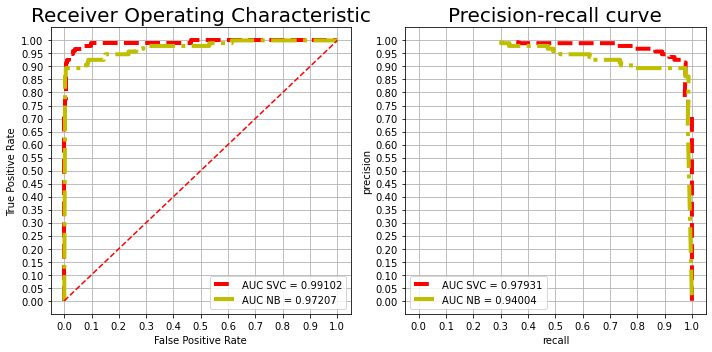

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)


# calculate the fpr and tpr for all thresholds of the classification
preds_SVC = SVC_pipeline.decision_function(X_test)
preds_NB = NB_pipeline.predict_proba(X_test)[:, 1]

y_true = y_test.copy()

fpr_SVC, tpr_SVC, threshold_SVC = metrics.roc_curve(y_true, preds_SVC)
roc_auc_SVC = metrics.roc_auc_score(y_true, preds_SVC, average='weighted')

fpr_NB, tpr_NB, threshold_NB = metrics.roc_curve(y_true, preds_NB)
roc_auc_NB = metrics.roc_auc_score(y_true, preds_NB, average='weighted')

# Receiver Operating Characteristic
ax[0].set_title('Receiver Operating Characteristic', size=20)
ax[0].plot(fpr_SVC, tpr_SVC, 'r--', label = 'AUC SVC = %.5f' % roc_auc_SVC, linewidth=4)
ax[0].plot(fpr_NB, tpr_NB, '-.y', label = 'AUC NB = %.5f' % roc_auc_NB, linewidth=4)
ax[0].legend(loc = 'lower right')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([-0.05, 1.05])
ax[0].set_ylim([-0.05, 1.05])
ax[0].set_yticks(np.arange(0, 1.01, 0.05))
ax[0].set_xticks(np.arange(0, 1.01, 0.1))
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[0].grid()

# Precision-recall curve
rec_SVC, pre_SVC, threshold = metrics.precision_recall_curve(y_true, preds_SVC)
pr_rec_SVC = metrics.average_precision_score(y_true, preds_SVC, average='weighted')

rec_NB, pre_NB, threshold = metrics.precision_recall_curve(y_true, preds_NB)
pr_rec_NB = metrics.average_precision_score(y_true, preds_NB, average='weighted')


ax[1].plot(rec_SVC, pre_SVC, 'r--', label='AUC SVC = %.5f' % pr_rec_SVC, linewidth=4)
ax[1].plot(rec_NB, pre_NB, '-.y', label='AUC NB = %.5f' % pr_rec_NB, linewidth=4)
ax[1].legend(loc = 'lower left')
ax[1].set_title('Precision-recall curve', size=20)
ax[1].set_ylabel('precision')
ax[1].set_xlabel('recall')
ax[1].set_xlim([-0.05, 1.05])
ax[1].set_ylim([-0.05, 1.05])
ax[1].set_xticks(np.arange(0, 1.01, 0.1))
ax[1].set_yticks(np.arange(0, 1.01, 0.05))
ax[1].grid()
plt.tight_layout()
plt.show()

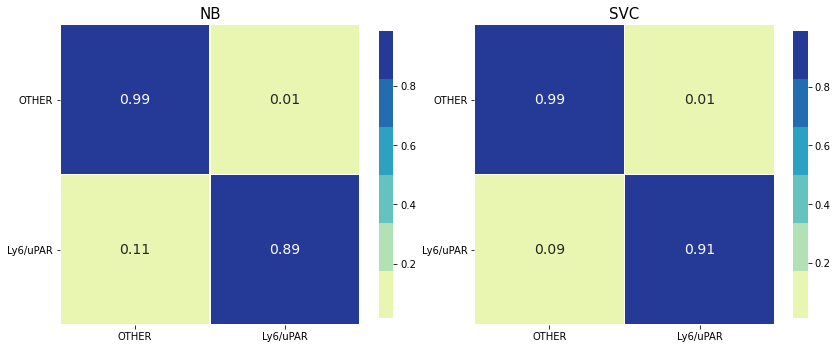

In [16]:
# Построение матрицы ошибок
conf_mat_m_NB = confusion_matrix(y_true=y_test, y_pred=NB_pred,
                                 normalize='true')
conf_mat_m_SVC = confusion_matrix(y_true=y_test, y_pred=SVC_pred,
                                  normalize='true')

# Строим HeatMap
fig , ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

m = sns.heatmap(conf_mat_m_NB, annot=True, fmt='.2f', linewidths=.3,
                annot_kws={"size": 14}, ax=ax[0],
                square=True, robust=True, 
                cmap=sns.color_palette("YlGnBu"), cbar_kws={'shrink': 0.7}
                )
g = sns.heatmap(conf_mat_m_SVC, annot=True, fmt='.2f', linewidths=.3,
                annot_kws={"size": 14}, ax=ax[1],
                square=True, robust=True, 
                cmap=sns.color_palette("YlGnBu"), cbar_kws={'shrink': 0.7}
                )
m.set_title('NB', size=15)
g.set_title('SVC', size=15)
m.set_xticklabels(['OTHER', 'Ly6/uPAR']) #, rotation=45)
m.set_yticklabels(['OTHER', 'Ly6/uPAR', ], rotation=360)
g.set_xticklabels(['OTHER', 'Ly6/uPAR']) #, rotation=45)
g.set_yticklabels(['OTHER', 'Ly6/uPAR',], rotation=360)

plt.show()

In [17]:
# Вывод метрик отчета классификации
print('NB\n', classification_report(y_test, NB_pred, labels=[1, 0], target_names=['Ly6/uPAR', 'OTHER']), '\n')
print('SVC\n', classification_report(y_test, SVC_pred, labels=[1, 0], target_names=['Ly6/uPAR', 'OTHER']))


NB
               precision    recall  f1-score   support

    Ly6/uPAR       0.95      0.89      0.92        94
       OTHER       0.97      0.99      0.98       352

    accuracy                           0.97       446
   macro avg       0.96      0.94      0.95       446
weighted avg       0.97      0.97      0.97       446
 

SVC
               precision    recall  f1-score   support

    Ly6/uPAR       0.98      0.91      0.95        94
       OTHER       0.98      0.99      0.99       352

    accuracy                           0.98       446
   macro avg       0.98      0.95      0.97       446
weighted avg       0.98      0.98      0.98       446



In [18]:
# Feauture importance

print(f'top 20 highest values NB{" "*15}top 20 highest values SVC\n')
top_NB = show_most_informative_features(NB_pipeline, 20)
top_SVC = show_most_informative_features(SVC_pipeline, 20)

for (coef_NB, fn_NB), (coef_SVC, fn_SVC) in zip(top_NB, top_SVC):
    print ("{:.5}   '{}' {} {:.5}   '{}'".format(coef_NB,
                                 fn_NB.upper(),
                                 3*'\t',
                                 coef_SVC,
                                 fn_SVC.upper()))


top 20 highest values NB               top 20 highest values SVC

-10.281   'ALGG' 			 0.041124   'CNS'
-10.281   'ALGGH' 			 0.042912   'TE'
-10.281   'CYTC' 			 0.046675   'TT'
-10.281   'LCNS' 			 0.048478   'KT'
-10.281   'LGGH' 			 0.048542   'SP'
-10.281   'LLLA' 			 0.053231   'SC'
-10.212   'EQPSGE' 			 0.058532   'CL'
-10.212   'QPSGE' 			 0.058591   'RC'
-10.147   'DRCN' 			 0.058796   'NC'
-10.147   'EQPSG' 			 0.061894   'KC'
-10.147   'GEQPS' 			 0.062944   'CP'
-10.147   'PSGE' 			 0.065333   'CV'
-10.147   'QPSG' 			 0.066671   'TC'
-10.087   'SGEQP' 			 0.066965   'GC'
-10.03   'NLCN' 			 0.070007   'LCN'
-9.9756   'EQPS' 			 0.072964   'LLL'
-9.9243   'GEQP' 			 0.082103   'CY'
-9.7845   'SGEQ' 			 0.098776   'LL'
-9.6242   'LLLL' 			 0.11649   'CC'
-9.4543   'DLCN' 			 0.15113   'CN'


/home/alexmakh/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


### Кросс-валидация

In [19]:
models = [('NB', NB_pipeline), ('SVC', SVC_pipeline)]
num_folds = 20
results_pr, results_f1, results_rec, results_roc = [], [], [], []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=1, shuffle=True)
    
    cv_results_pr = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision')
    results_pr.append(cv_results_pr)
    
    cv_results_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    results_f1.append(cv_results_f1)

    cv_results_rec = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall')
    results_f1.append(cv_results_rec)

    cv_results_roc = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results_f1.append(cv_results_roc)
    
    m_fit = model.fit(X_train, y_train)
    m_predict = model.predict(X_test)

    m_score = model.score(X_test, y_test)

    msg = "%s: train f1 %.3f (%.3f) / test = %.3f" % (name, cv_results_f1.mean(), cv_results_f1.std(), m_score)
    print(msg)

NB: train f1 0.883 (0.107) / test = 0.969
SVC: train f1 0.918 (0.088) / test = 0.978


In [20]:
cross_res = results_f1 + results_pr + results_rec + results_roc
labels = ['NB f1', 'SVC f1',
          'NB prec', 'SVC prec',
          'NB recall', 'SVC recall',
          'NB roc auc', 'SVC roc auc',]

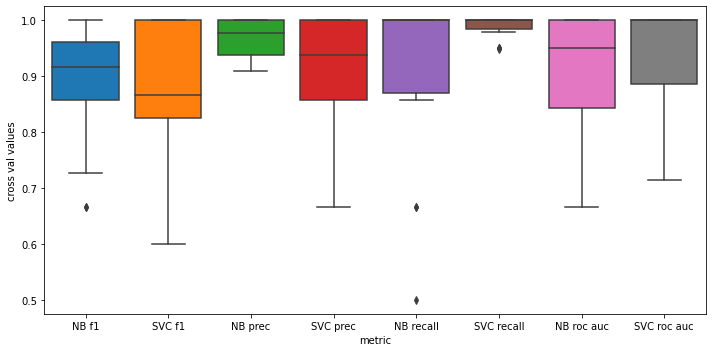

In [21]:
df = pd.DataFrame({i: j for i, j in zip(labels, cross_res)})
df = df.melt(var_name='metric', value_name='cross val values')

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='cross val values', x='metric', saturation=1)
plt.tight_layout()
plt.show()